<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/pytorch/CGAN_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN (Conditional GAN), MNIST

In [1]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [8]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint
import cv2


#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = [str(x) for x in range(10)] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 100
cfg.INPUT_MODE = None
cfg.INPUT_CMAP = None

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # None, RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = 'gray' # pyplot cmap


cfg.G_DIM = 32
cfg.D_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'CGAN_MNIST'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 5_000
cfg.TRAIN.MINIBATCH = 128
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.BCELoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 4
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'CLASS_NUM': 10,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'D_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CMAP': None,
 'INPUT_MODE': None,
 'INPUT_Z_DIM': 100,
 'OUTPUT_CHANNEL': 1,
 'OUTPUT_CMAP': 'gray',
 'OUTPUT_HEIGHT': 28,
 'OUTPUT_MODE': None,
 'OUTPUT_WIDTH': 28,
 'PREFIX': 'CGAN_MNIST',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 4,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/CGAN_MNIST_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/CGAN_MNIST_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 5000,
           'LEARNING_PARAMS_D': {'betas': [0.5, 0.9], 'lr': 0.0002},
           'LEARNING_PARAMS_G': {'betas': [0.5, 0.9], 'lr'

## Define Model

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM + cfg.CLASS_NUM, cfg.G_DIM * 8, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'G_layer_1_ReLU' : torch.nn.ReLU(),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 8, cfg.G_DIM * 4, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_2_ReLU' : torch.nn.ReLU(),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL + cfg.CLASS_NUM, cfg.D_DIM, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_2_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 2, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], padding=0, stride=1, bias=False),
            'D_layer_out_sigmoid' : torch.nn.Sigmoid()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

## Utility

In [0]:
def result_show(G, Xs, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    Gz = G(Xs)
    Gz = Gz.detach().cpu().numpy()
    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    
    if cfg.OUTPUT_CHANNEL == 1:
        Gz = Gz[:, 0]
    else:
        Gz = Gz.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(Gz))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show output
        _G = Gz[i]

        plt.subplot(1, show_max, i + 1)
        plt.imshow(_G, cmap=cmap_out)
        plt.axis('off')
        plt.title(cfg.CLASS_LABEL[i])

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

#---
# preprocess for torchvision.datasets
#---
def preprocess(Xs, cfg, mode, hf=False, vf=False, rot=False):
    xs = []

    for x in Xs:
        # resize
        x = cv2.resize(x, (cfg.OUTPUT_WIDTH, cfg.OUTPUT_HEIGHT)).astype(np.float32)
        
        # channel BGR -> Gray
        if mode == 'GRAY':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = np.expand_dims(x, axis=-1)
        elif mode == 'EDGE':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = cv2.Canny(x, 100, 150)
            x = np.expand_dims(x, axis=-1)

        # horizontal flip
        if hf and np.random.rand() < 0.5:
            x = x[:, ::-1]

        # vertical flip
        if vf and np.random.rand() < 0.5:
            x = x[::-1]

        # rotation
        if rot != False:
            rot = np.random.randint(0, 360, 1) // cfg.TRAIN.DATA_ROTATION * cfg.TRAIN.DATA_ROTATION

            scale = 1

            _h, _w = x.shape[:2]
            _c = 1
            if len(x.shape) == 3:
                _c = x.shape[2]

            max_side = max(_h, _w)
            tmp = np.zeros((max_side, max_side, _c))
            tx = int((max_side - _w) / 2)
            ty = int((max_side - _h) / 2)
            tmp[ty: ty+_h, tx: tx+_w] = x.copy()
            M = cv2.getRotationMatrix2D((max_side / 2, max_side / 2), rot, scale)
            _x = cv2.warpAffine(tmp, M, (max_side, max_side))
            x = _x[tx:tx+_w, ty:ty+_h]

        if mode == 'CLASS_LABEL':
            _x = x
            x = np.zeros((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.CLASS_NUM), dtype=np.int)

            for i, (_, vs) in enumerate(cfg.CLASS_LABEL.items()):
                ind = (_x[..., 0] == vs[0]) * (_x[..., 1] == vs[1]) * (_x[..., 2] == vs[2])
                x[..., i][ind] = 1

        else:
            # normalization [0, 255] -> [-1, 1]
            x = x / 127.5 - 1

            # channel BGR -> RGB
            #if mode in ['RGB']:
            #    x = x[..., ::-1]

        xs.append(x)
                
    xs = np.array(xs, dtype=np.float32)
    if cfg.CHANNEL_AXIS == 1:
        if len(xs.shape) == 4:
            xs = xs.transpose(0, 3, 1, 2)
        else:
            xs = np.expand_dims(xs, axis=1)
    else:
        if len(xs.shape) == 3:
            xs = np.expand_dims(xs, axis=-1)

    return xs

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 7, 7]       1,379,840
       BatchNorm2d-2            [-1, 256, 7, 7]             512
              ReLU-3            [-1, 256, 7, 7]               0
   ConvTranspose2d-4          [-1, 128, 14, 14]         524,288
       BatchNorm2d-5          [-1, 128, 14, 14]             256
              ReLU-6          [-1, 128, 14, 14]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           2,048
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 1,906,944
Trainable params: 1,906,944
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.87
Params size (MB): 7.27
Estimated Total Size (MB): 8.15
----------------------------------------------------------------
--------------------------------------

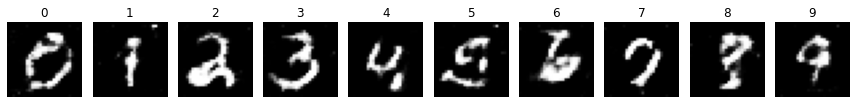

Iter:550, LossG (fake:0.9378), LossD:1.2531 (real:0.5323, fake:0.7208)
Iter:600, LossG (fake:1.2069), LossD:1.2364 (real:0.4257, fake:0.8107)
save G >> models/CGAN_MNIST_G_iter600.pt, D >> models/CGAN_MNIST_D_iter600.pt
Iter:650, LossG (fake:0.5342), LossD:1.2597 (real:0.8288, fake:0.4309)
Iter:700, LossG (fake:1.1544), LossD:1.2389 (real:0.4809, fake:0.7580)
Iter:750, LossG (fake:0.5154), LossD:1.3996 (real:1.1158, fake:0.2839)
Iter:800, LossG (fake:0.7534), LossD:1.1939 (real:0.6423, fake:0.5516)
save G >> models/CGAN_MNIST_G_iter800.pt, D >> models/CGAN_MNIST_D_iter800.pt
Iter:850, LossG (fake:0.8923), LossD:1.1797 (real:0.6181, fake:0.5616)
Iter:900, LossG (fake:1.0494), LossD:1.2744 (real:0.4049, fake:0.8694)
Iter:950, LossG (fake:0.7840), LossD:1.2096 (real:0.6304, fake:0.5792)
Iter:1000, LossG (fake:1.0211), LossD:1.2262 (real:0.4951, fake:0.7311)
save G >> models/CGAN_MNIST_G_iter1000.pt, D >> models/CGAN_MNIST_D_iter1000.pt
result was saved to >> result/CGAN_MNIST_result_iter1

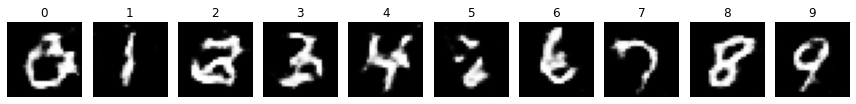

Iter:1050, LossG (fake:1.0050), LossD:1.2889 (real:0.5167, fake:0.7722)
Iter:1100, LossG (fake:0.5574), LossD:1.3005 (real:0.8079, fake:0.4926)
Iter:1150, LossG (fake:0.6158), LossD:1.2836 (real:0.7679, fake:0.5157)
Iter:1200, LossG (fake:0.4914), LossD:1.3058 (real:0.9045, fake:0.4013)
save G >> models/CGAN_MNIST_G_iter1200.pt, D >> models/CGAN_MNIST_D_iter1200.pt
Iter:1250, LossG (fake:0.8742), LossD:1.2385 (real:0.6522, fake:0.5863)
Iter:1300, LossG (fake:0.5413), LossD:1.2969 (real:0.8580, fake:0.4389)
Iter:1350, LossG (fake:0.4766), LossD:1.3191 (real:0.8519, fake:0.4672)
Iter:1400, LossG (fake:0.8878), LossD:1.2750 (real:0.5752, fake:0.6998)
save G >> models/CGAN_MNIST_G_iter1400.pt, D >> models/CGAN_MNIST_D_iter1400.pt
Iter:1450, LossG (fake:0.6646), LossD:1.2436 (real:0.7290, fake:0.5147)
Iter:1500, LossG (fake:1.2876), LossD:1.4579 (real:0.2940, fake:1.1638)
result was saved to >> result/CGAN_MNIST_result_iter1500.jpg


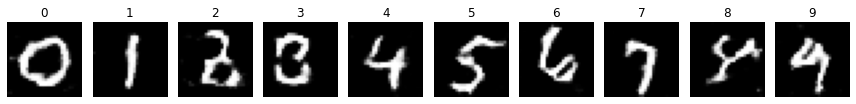

Iter:1550, LossG (fake:0.8373), LossD:1.2439 (real:0.6103, fake:0.6335)
Iter:1600, LossG (fake:0.7224), LossD:1.2615 (real:0.6178, fake:0.6437)
save G >> models/CGAN_MNIST_G_iter1600.pt, D >> models/CGAN_MNIST_D_iter1600.pt
Iter:1650, LossG (fake:1.0198), LossD:1.3221 (real:0.4956, fake:0.8265)
Iter:1700, LossG (fake:0.4475), LossD:1.3345 (real:0.9028, fake:0.4318)
Iter:1750, LossG (fake:0.4079), LossD:1.3343 (real:0.8795, fake:0.4548)
Iter:1800, LossG (fake:0.9590), LossD:1.2927 (real:0.5823, fake:0.7104)
save G >> models/CGAN_MNIST_G_iter1800.pt, D >> models/CGAN_MNIST_D_iter1800.pt
Iter:1850, LossG (fake:1.0348), LossD:1.2900 (real:0.5366, fake:0.7534)
Iter:1900, LossG (fake:0.6336), LossD:1.3446 (real:0.8257, fake:0.5189)
Iter:1950, LossG (fake:0.6724), LossD:1.2865 (real:0.7329, fake:0.5537)
Iter:2000, LossG (fake:0.4804), LossD:1.2747 (real:0.8475, fake:0.4272)
save G >> models/CGAN_MNIST_G_iter2000.pt, D >> models/CGAN_MNIST_D_iter2000.pt
result was saved to >> result/CGAN_MNIST

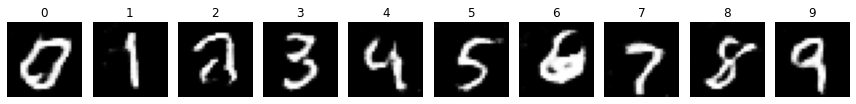

Iter:2050, LossG (fake:0.7045), LossD:1.2970 (real:0.6438, fake:0.6532)
Iter:2100, LossG (fake:0.6508), LossD:1.3131 (real:0.7565, fake:0.5566)
Iter:2150, LossG (fake:0.6854), LossD:1.2968 (real:0.5715, fake:0.7254)
Iter:2200, LossG (fake:0.9717), LossD:1.2831 (real:0.5505, fake:0.7325)
save G >> models/CGAN_MNIST_G_iter2200.pt, D >> models/CGAN_MNIST_D_iter2200.pt
Iter:2250, LossG (fake:0.8295), LossD:1.2554 (real:0.6302, fake:0.6252)
Iter:2300, LossG (fake:0.8986), LossD:1.3237 (real:0.5865, fake:0.7372)
Iter:2350, LossG (fake:0.8215), LossD:1.3058 (real:0.5465, fake:0.7593)
Iter:2400, LossG (fake:0.7478), LossD:1.2925 (real:0.6675, fake:0.6250)
save G >> models/CGAN_MNIST_G_iter2400.pt, D >> models/CGAN_MNIST_D_iter2400.pt
Iter:2450, LossG (fake:0.6374), LossD:1.3363 (real:0.7995, fake:0.5368)
Iter:2500, LossG (fake:0.7354), LossD:1.2795 (real:0.6823, fake:0.5972)
result was saved to >> result/CGAN_MNIST_result_iter2500.jpg


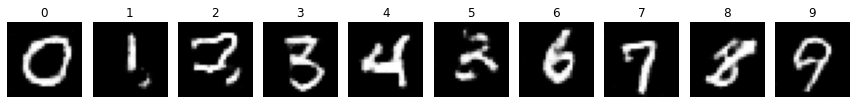

Iter:2550, LossG (fake:0.6307), LossD:1.3259 (real:0.7874, fake:0.5385)
Iter:2600, LossG (fake:0.7670), LossD:1.2935 (real:0.5984, fake:0.6951)
save G >> models/CGAN_MNIST_G_iter2600.pt, D >> models/CGAN_MNIST_D_iter2600.pt
Iter:2650, LossG (fake:0.7406), LossD:1.3182 (real:0.8082, fake:0.5101)
Iter:2700, LossG (fake:0.9178), LossD:1.3692 (real:0.4586, fake:0.9106)
Iter:2750, LossG (fake:0.7896), LossD:1.3745 (real:0.4153, fake:0.9592)
Iter:2800, LossG (fake:0.4636), LossD:1.3990 (real:0.9970, fake:0.4019)
save G >> models/CGAN_MNIST_G_iter2800.pt, D >> models/CGAN_MNIST_D_iter2800.pt
Iter:2850, LossG (fake:0.8166), LossD:1.3415 (real:0.6980, fake:0.6435)
Iter:2900, LossG (fake:1.0972), LossD:1.3012 (real:0.5474, fake:0.7538)
Iter:2950, LossG (fake:0.7012), LossD:1.3615 (real:0.7030, fake:0.6585)
Iter:3000, LossG (fake:1.1763), LossD:1.3287 (real:0.5551, fake:0.7736)
save G >> models/CGAN_MNIST_G_iter3000.pt, D >> models/CGAN_MNIST_D_iter3000.pt
result was saved to >> result/CGAN_MNIST

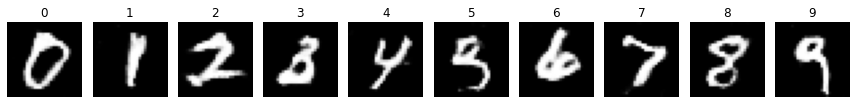

Iter:3050, LossG (fake:0.6874), LossD:1.3839 (real:0.7066, fake:0.6773)
Iter:3100, LossG (fake:0.9656), LossD:1.4607 (real:0.3912, fake:1.0694)
Iter:3150, LossG (fake:0.5224), LossD:1.3428 (real:0.8599, fake:0.4829)
Iter:3200, LossG (fake:0.6581), LossD:1.3280 (real:0.7231, fake:0.6050)
save G >> models/CGAN_MNIST_G_iter3200.pt, D >> models/CGAN_MNIST_D_iter3200.pt
Iter:3250, LossG (fake:0.7337), LossD:1.2856 (real:0.6810, fake:0.6046)
Iter:3300, LossG (fake:0.8128), LossD:1.3017 (real:0.5656, fake:0.7361)
Iter:3350, LossG (fake:0.9239), LossD:1.3829 (real:0.4378, fake:0.9451)
Iter:3400, LossG (fake:0.8345), LossD:1.3650 (real:0.5560, fake:0.8090)
save G >> models/CGAN_MNIST_G_iter3400.pt, D >> models/CGAN_MNIST_D_iter3400.pt
Iter:3450, LossG (fake:0.8345), LossD:1.2877 (real:0.6008, fake:0.6869)
Iter:3500, LossG (fake:0.7197), LossD:1.3185 (real:0.7768, fake:0.5417)
result was saved to >> result/CGAN_MNIST_result_iter3500.jpg


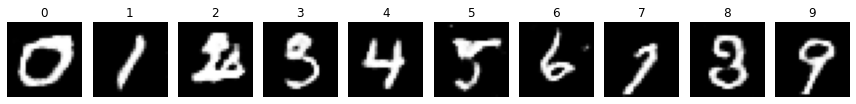

Iter:3550, LossG (fake:0.4717), LossD:1.4323 (real:0.8893, fake:0.5430)
Iter:3600, LossG (fake:0.7932), LossD:1.3046 (real:0.6238, fake:0.6808)
save G >> models/CGAN_MNIST_G_iter3600.pt, D >> models/CGAN_MNIST_D_iter3600.pt
Iter:3650, LossG (fake:0.7400), LossD:1.3297 (real:0.7342, fake:0.5955)
Iter:3700, LossG (fake:0.8159), LossD:1.3356 (real:0.6433, fake:0.6923)
Iter:3750, LossG (fake:1.0059), LossD:1.3348 (real:0.5272, fake:0.8076)
Iter:3800, LossG (fake:0.6165), LossD:1.3436 (real:0.8242, fake:0.5194)
save G >> models/CGAN_MNIST_G_iter3800.pt, D >> models/CGAN_MNIST_D_iter3800.pt
Iter:3850, LossG (fake:0.7755), LossD:1.3505 (real:0.5556, fake:0.7948)
Iter:3900, LossG (fake:0.9506), LossD:1.3460 (real:0.5464, fake:0.7996)
Iter:3950, LossG (fake:0.8375), LossD:1.3071 (real:0.6460, fake:0.6611)
Iter:4000, LossG (fake:0.8030), LossD:1.3356 (real:0.7002, fake:0.6354)
save G >> models/CGAN_MNIST_G_iter4000.pt, D >> models/CGAN_MNIST_D_iter4000.pt
result was saved to >> result/CGAN_MNIST

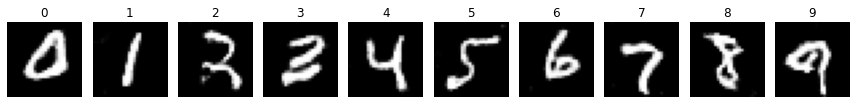

Iter:4050, LossG (fake:0.8069), LossD:1.3056 (real:0.6914, fake:0.6142)
Iter:4100, LossG (fake:0.8835), LossD:1.3164 (real:0.6289, fake:0.6875)
Iter:4150, LossG (fake:0.7911), LossD:1.2969 (real:0.6194, fake:0.6775)
Iter:4200, LossG (fake:0.7473), LossD:1.3476 (real:0.6684, fake:0.6792)
save G >> models/CGAN_MNIST_G_iter4200.pt, D >> models/CGAN_MNIST_D_iter4200.pt
Iter:4250, LossG (fake:0.6535), LossD:1.2788 (real:0.7060, fake:0.5728)
Iter:4300, LossG (fake:0.8697), LossD:1.3028 (real:0.6253, fake:0.6775)
Iter:4350, LossG (fake:0.8587), LossD:1.4042 (real:0.5065, fake:0.8977)
Iter:4400, LossG (fake:0.6156), LossD:1.3506 (real:0.7515, fake:0.5992)
save G >> models/CGAN_MNIST_G_iter4400.pt, D >> models/CGAN_MNIST_D_iter4400.pt
Iter:4450, LossG (fake:0.7470), LossD:1.3341 (real:0.6886, fake:0.6455)
Iter:4500, LossG (fake:0.6936), LossD:1.3514 (real:0.7609, fake:0.5905)
result was saved to >> result/CGAN_MNIST_result_iter4500.jpg


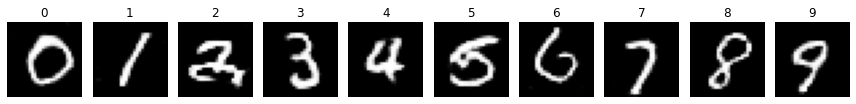

Iter:4550, LossG (fake:0.8511), LossD:1.3435 (real:0.5984, fake:0.7451)
Iter:4600, LossG (fake:0.6493), LossD:1.3237 (real:0.7238, fake:0.6000)
save G >> models/CGAN_MNIST_G_iter4600.pt, D >> models/CGAN_MNIST_D_iter4600.pt
Iter:4650, LossG (fake:0.9173), LossD:1.2903 (real:0.5527, fake:0.7375)
Iter:4700, LossG (fake:0.8423), LossD:1.3235 (real:0.6202, fake:0.7033)
Iter:4750, LossG (fake:0.8358), LossD:1.3289 (real:0.6900, fake:0.6389)
Iter:4800, LossG (fake:0.5401), LossD:1.3949 (real:0.8543, fake:0.5406)
save G >> models/CGAN_MNIST_G_iter4800.pt, D >> models/CGAN_MNIST_D_iter4800.pt
Iter:4850, LossG (fake:0.7151), LossD:1.3414 (real:0.7017, fake:0.6397)
Iter:4900, LossG (fake:0.7301), LossD:1.3033 (real:0.7025, fake:0.6008)
Iter:4950, LossG (fake:0.4849), LossD:1.4078 (real:0.9827, fake:0.4251)
Iter:5000, LossG (fake:0.7581), LossD:1.3162 (real:0.6837, fake:0.6325)
save G >> models/CGAN_MNIST_G_iter5000.pt, D >> models/CGAN_MNIST_D_iter5000.pt
result was saved to >> result/CGAN_MNIST

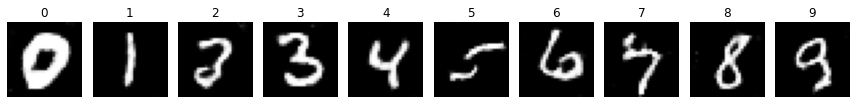

final paramters were saved to G >> models/CGAN_MNIST_G_final.pt, D >> models/CGAN_MNIST_D_final.pt
loss was saved to >> result/CGAN_MNIST_loss.csv


In [14]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    summary(G,(cfg.INPUT_Z_DIM + cfg.CLASS_NUM, 1, 1), device=cfg.DEVICE_TYPE)
    summary(D,(cfg.OUTPUT_CHANNEL + cfg.CLASS_NUM, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = np.array(trainset.data)
    train_ys = np.array(trainset.targets)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ys = train_ys[mb_ind]
        
        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        
        #  add conditional
        z_con = torch.zeros([cfg.TRAIN.MINIBATCH, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
        z_con[range(cfg.TRAIN.MINIBATCH), ys] = 1
        z = torch.cat([z, z_con], dim=1)

        # forward
        Gz = G(z)
        #Gz = torch.reshape(Gz, [cfg.TRAIN.MINIBATCH, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

        #  add conditional
        Gz_con = torch.zeros([cfg.TRAIN.MINIBATCH, cfg.CLASS_NUM, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH], dtype=torch.float).to(cfg.DEVICE)
        Gz_con[range(cfg.TRAIN.MINIBATCH), ys] = 1
        Gz = torch.cat([Gz, Gz_con], dim=1)
        
        Xs = torch.cat([Xs, Gz_con], dim=1)
        
        D_real = D(Xs)[..., 0, 0, 0]
        D_fake = D(Gz)[..., 0, 0, 0]

        # update D
        loss_D_real = cfg.TRAIN.LOSS_FUNCTION(D_real, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D_fake = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.zeros(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        opt_D.step()

        # update G
        opt_G.zero_grad()
        Gz = G(z)
        Gz = torch.cat([Gz, Gz_con], dim=1)
        D_fake = D(Gz)[..., 0, 0, 0]

        loss_G = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_G.backward()
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.CLASS_NUM, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            #  add conditional
            z_con = torch.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
            z_con[range(cfg.CLASS_NUM), range(cfg.CLASS_NUM)] = 1
            z = torch.cat([z, z_con], dim=1)
            
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)


    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------


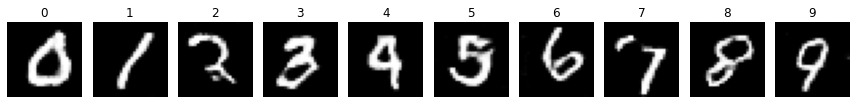

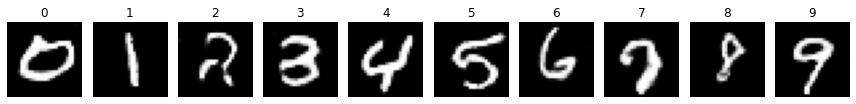

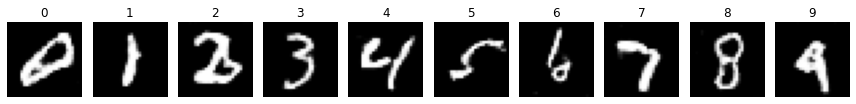

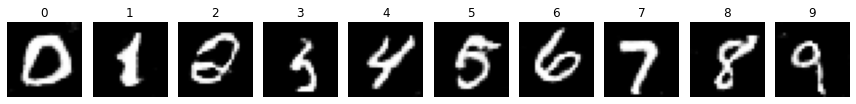

In [15]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.CLASS_NUM, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        #  add conditional
        z_con = torch.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
        z_con[range(cfg.CLASS_NUM), range(cfg.CLASS_NUM)] = 1
        z = torch.cat([z, z_con], dim=1)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, 
                   show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
